In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
MIN_MATCH_COUNT = 10

img2 = cv2.imread('images/leftturn_box_small.png',0) # #templateImage

img1_3channel = cv2.imread('images/uturn_box.png')
img1 = cv2.imread('images/bin_img_0100.jpg',0) # sceneImage

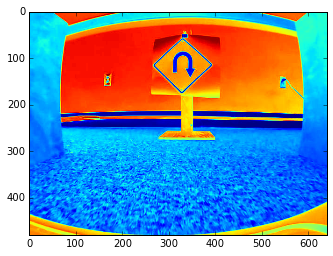

In [4]:
plt.imshow(img1)

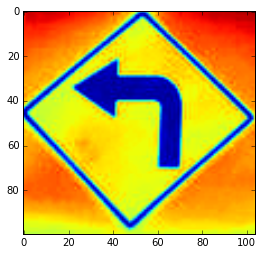

In [5]:
plt.imshow(img2)

In [6]:
# Initiate SIFT detector
sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [7]:
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [8]:
# bf = cv2.BFMatcher()
# # matches = bf.knnMatch(des1, des2, k=2)

In [9]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [10]:
print len(good)
for match in sorted(good, key=lambda val: val.distance):
    print match.distance

70
28.809720993
30.5777702332
33.8821487427
33.9852905273
37.5898933411
40.4969139099
48.0520553589
48.8159828186
52.8677597046
65.1076049805
90.5869750977
124.414627075
140.249771118
141.477920532
144.131881714
165.472045898
171.277557373
172.319473267
177.220199585
182.860595703
192.288848877
194.689498901
195.770278931
197.701797485
197.853485107
197.936859131
198.335571289
199.491851807
202.635147095
205.212081909
205.248626709
210.259368896
211.049758911
211.419021606
212.440582275
215.45765686
216.95161438
217.112869263
217.320037842
219.152908325
220.485824585
220.540252686
221.199005127
224.459350586
225.328643799
225.776443481
226.214492798
226.94934082
231.41305542
233.291656494
233.801193237
233.987182617
237.151855469
238.058822632
238.989532471
241.708496094
242.177627563
244.906097412
249.106399536
249.937988281
249.985992432
250.007995605
251.654525757
253.469924927
261.063201904
263.982940674
264.512756348
267.056182861
285.524078369
297.16998291


In [11]:
def drawMatches(img1, kp1, img2, kp2, matches, masks):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    masks - a list of which matches are inliers (1?) or outliers (0?)
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mask, mat in zip(masks,matches):

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        
        cv2.circle(out, (int(x1),int(y1)), 4, (255*mask, 0, 255*(1-mask)), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255*mask, 0, 255*(1-mask)), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyWindow('Matched Features')

    # Also return the image if you'd like a copy
    return out

In [12]:
# Show only the top 10 matches - also save a copy for use later
# out = drawMatches(img1, kp1, img2, kp2, good[:15], mask)

In [13]:
src_pts = np.float32([kp1[match.queryIdx].pt for match in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[match.trainIdx].pt for match in good]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

print M

print mask

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, M)



[[ -3.20454997e-02  -1.89856517e-01   3.44048921e+01]
 [ -2.56995392e-02  -1.51970762e-01   2.75710892e+01]
 [ -9.36559179e-04  -5.50167079e-03   1.00000000e+00]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]]


In [14]:
img1.shape

(480, 640)

In [15]:
kai = np.asarray(img1_3channel, dtype='float32')
print kai.shape
print M.shape

(662, 771, 3)
(3, 3)


In [16]:
img_T = cv2.warpPerspective(img1, M, img2.shape)

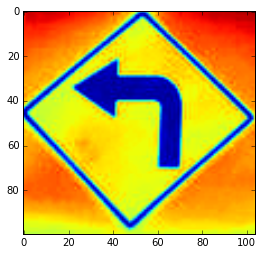

In [17]:
plt.imshow(img2)

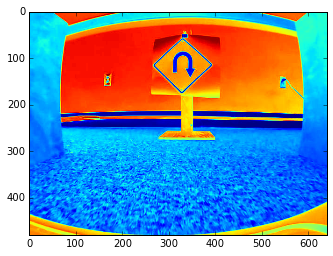

In [18]:
plt.imshow(img1)

In [19]:
img_T.shape

(104, 100)

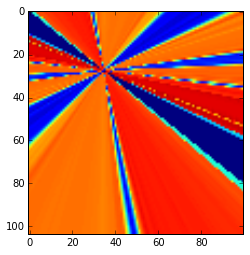

In [20]:
plt.imshow(img_T)

In [21]:
out = drawMatches(img1, kp1, img2, kp2, good, matchesMask)

In [22]:
a = np.array([[1, 2], [4, 5], [7, 8]], dtype='float32')
h = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype='float32')
a = np.array([a])

pointsOut = cv2.perspectiveTransform(kai[:,:,:2], M)
print a
# print h
print pointsOut

[[[ 1.  2.]
  [ 4.  5.]
  [ 7.  8.]]]
[[[ 34.61877441  27.66606522]
  [ 34.61877441  27.66606522]
  [ 34.61877441  27.66606522]
  ..., 
  [ 34.63664246  27.67505074]
  [ 34.63664246  27.67505074]
  [ 34.63664246  27.67505074]]

 [[ 34.61877441  27.66606522]
  [ 34.61877441  27.66606522]
  [ 34.61877441  27.66606522]
  ..., 
  [ 34.63664246  27.67505074]
  [ 34.63664246  27.67505074]
  [ 34.63664246  27.67505074]]

 [[ 34.61877441  27.66606522]
  [ 34.61877441  27.66606522]
  [ 34.61877441  27.66606522]
  ..., 
  [ 34.63664246  27.67505074]
  [ 34.63664246  27.67505074]
  [ 34.63664246  27.67505074]]

 ..., 
 [[ 34.65673828  27.68329239]
  [ 34.65673828  27.68329239]
  [ 34.65673828  27.68329239]
  ..., 
  [ 34.71908569  27.71424675]
  [ 34.71908569  27.71424675]
  [ 34.71908569  27.71424675]]

 [[ 34.65673828  27.68329239]
  [ 34.65673828  27.68329239]
  [ 34.65673828  27.68329239]
  ..., 
  [ 34.71908569  27.71424675]
  [ 34.71908569  27.71424675]
  [ 34.71908569  27.71424675]]

 [[ 3

TypeError: Invalid dimensions for image data

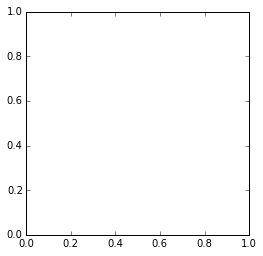

In [23]:
plt.imshow(pointsOut)